##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

Then we separate the tweet text and the label (sentiment). 

In [2]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [3]:
#Split data
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X_train_raw,Y_train,test_size=0.28, random_state=30027)

In [5]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from bs4 import BeautifulSoup
import re
import unidecode
from nltk.tokenize import TweetTokenizer
from string import punctuation
import contractions
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True) 
ps = nltk.PorterStemmer()
wordnet = nltk.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
stopwords = []
# exclude words from stopwords list
for i in stop_words:
    if i != 'not' and i != 'no':
        stopwords.append(i)
    

In [145]:
X_train

[' @teutonicknight7 what biological differences? do white democrats and white supremacists have the same biological dna?',
 " 7th round:  when is niall's birthday?  first to get 5 points wins the dm with liam http://t.co/invt057za4\t",
 '  how will you spend your courage? jane mead reads from world of made and unmade. #nbawards #miamibookfair2016 https://t.co/okqfjg5msh',
 ' "ryan braun\'s home run in the 6th puts gives the brewers a 1-0 lead.  a.j. pollock, goldy, and david peralta will look to answer."\t',
 'so after watching straight outta compton (which was amazing) ice cube may have had one of the best diss tracks of all time! lol',
 'glo premier league star striker tunde adeniji on thursday scored twice as the super eagles defeated amakson ac... http://t.co/l7m0lm7oqh',
 ' new on @twitter . big fan of @nickiminaj and @arianagrande #arianagrande #nickiminaj #barbies #barbz #arianators‚ä¶ https://t.co/ekupd5r50s',
 ' the last thing we should be doing when our climate is at such a c

In [6]:
def remove_links(text):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

def remove_email(text):
    return re.sub(r'[\.a-zA-Z0-9_-]*@[\.a-zA-Z0-9_-]*', '', text)



def remove_accented_chars(text):

    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text
def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_stopwords(text):
    return ' '.join([wordnet.lemmatize(i) for i in text.split() if i not in stopwords])

def remove_punc(text):
    return ''.join([i.casefold() for i in text if i not in punctuation])

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


#  ps.stem(word)

def remove_not_alpha(text):
    return re.sub(r'[^\s\.a-zA-Z0-9_-]+', '', text)

def preprocess(text):
    
#     text = text.replace(r'\n','').replace(r'\m','').replace(r'\r','').replace(r'\t','') 
    no_email = remove_email(text)
    no_accented_chars = remove_accented_chars(no_email)
    no_links = remove_links(no_accented_chars) 
    no_white_space = remove_whitespace(no_links)
    no_punc = remove_punc(no_white_space)  
    no_contractions = expand_contractions(no_punc)
    no_html_tags = strip_html_tags(no_contractions)
    no_num = remove_num(no_html_tags)
    no_stopwords = remove_stopwords(no_num)
    no_alpha = remove_not_alpha(no_stopwords)
    tok = tknzr.tokenize(no_alpha)
    return " ".join([ps.stem(word) for word in tok])

def prepare(text): 
    res = []
    for line in text:
        line = preprocess(line) 
        res.append(line)    
    return res    
X_train_clean = prepare(X_train)
X_valid_clean = prepare(X_valid) 


In [147]:
X_train_clean


['biolog differ white democrat white supremacist biolog dna',
 'th round niall birthday first get point win dm liam',
 'spend courag jane mead read world made unmad nbaward miamibookfair',
 'ryan braun home run th put give brewer lead aj pollock goldi david peralta look answer',
 'watch straight outta compton amaz ice cube may one best di track time lol',
 'glo premier leagu star striker tund adeniji thursday score twice super eagl defeat amakson ac',
 'new big fan arianagrand nickiminaj barbi barbz arianatorsap',
 'last thing climat critic turn point make fossil fuel',
 'guy go add kendrick lamar new mixtap black friday',
 'sell one jason aldean ticket darien lake show thursday august th contact interest',
 'may th star war day',
 'maduro pin head festiv strife not world watch freevenezuela',
 'exactli not verifi voter registr system id noncitizen differ',
 'featur film gift star chri evan fit tomorrow fri work mon',
 'john cena may not abl beat seth rollin least stop boulder save sco

### Preprocessing: Vectorization
**Bag of Words (BoW)**

In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from tabulate import tabulate

BoW_vectorizer_12 = CountVectorizer(ngram_range=(1,2))
#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW_12 = BoW_vectorizer_12.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_BoW_12 = BoW_vectorizer_12.transform(X_valid_clean)


We can save the created vocabulary for the given dataset in a separate file.

In [8]:
print(X_train_BoW_12.shape)

(15697, 127999)


### Preprocessing: Vectorization
**TFIDF**

In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [158]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

# #Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)

# #Use the feature set (vocabulary) from Train to vectorise the Test dataset 
# X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)



In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf_12 = tfidf_vectorizer.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_tfidf_12 = tfidf_vectorizer.transform(X_valid_clean)


In [ ]:
# #Let's see one example tweet using the TFIDF feature space
# print(X_train_tfidf[1])

### Preprocessing: feature selection 
**select kbest + chi2** 

In [150]:
from sklearn.feature_selection import SelectKBest, chi2

def chi(k_value):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_12 = selector.fit_transform(X_train_BoW_12 ,y_train)
    x_test_chi_12 = selector.transform(X_valid_BoW_12)

    return x_train_chi_12, x_test_chi_12



**select kbest + VarianceThreshold** 

In [ ]:

#
#Not working!
#MIC
from sklearn.feature_selection import SelectKBest,  mutual_info_classif
def mic(m_value):
    selector = SelectKBest(mutual_info_classif,k=m_value)
    x_train_mic_12 = selector.fit_transform(X_train_BoW_12 ,y_train)
    x_test_mic_12 = selector.transform(X_valid_BoW_12)

    return x_train_mic_12, x_test_mic_12

x_train_mic, x_test_mic = mic(500)


#Variance
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold= 0.0001)
x_var_train = selector.fit_transform(X_train_BoW_12, y_train)
x_var_test = selector.transform(X_valid_BoW_12)



### Model: Logistic Regression
 

**BoW**

In [183]:
from sklearn.model_selection import GridSearchCV

def gs_LogisticRegression(x_train):
    parameters_lr = {'solver':('newton-cg','lbfgs','sag','saga'),'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'multi_class':('auto','ovr','multinomial')}
    lr = LogisticRegression(max_iter=2000)
    gs = GridSearchCV(lr,parameters_lr)
    gs.fit(x_train,y_train)

    return gs.best_estimator_, gs.best_score_


In [ ]:
#This function find the best params and scores 
# Not working#
def gs_result_mic():
    best_params_mic = []
    best_scores_mic = []
    
    x_train_mic, x_test_mic = mic(500)
    gs_params_mic, gs_score_mic = gs_LogisticRegression(x_train_mic)
    best_params_mic.append(gs_params_mic)
    best_scores_mic.append(gs_score_mic)


    return best_params_mic, best_scores_mic, x_train_mic, x_test_mic

best_params_mic, best_scores_mic, x_train_mic, x_test_mic = gs_result_mic()

In [179]:
def gs_result_chi_lr():
    best_params_chi = []
    best_scores_chi = []
    
    for i in range(500,2000,500):
        x_train_chi, x_test_chi = chi(i)
        gs_params_chi, gs_score_chi = gs_LogisticRegression(x_train_chi)
        best_params_chi.append(gs_params_chi)
        best_scores_chi.append(gs_score_chi)

    return best_params_chi, best_scores_chi, x_train_chi, x_test_chi

#best_params_chi_lr, best_scores_chi_lr, x_train_chi_lr, x_test_chi_lr = gs_result_chi_lr()


In [ ]:
#This function find the best params and scores 
# Not working#
def gs_result_var():
    best_params_var = []
    best_scores_var = []

    x_train_var, x_test_var = variance(0.0001)
    gs_params_var, gs_score_var = gs_LogisticRegression(x_train_var)
    best_params_var.append(gs_params_var)
    best_scores_var.append(gs_score_var)

    return best_params_var, best_scores_var, x_train_var, x_test_var

best_params_var, best_scores_var, x_train_var, x_test_var = gs_result_var()

In [209]:
#C, solver, multi_class, penalty, max_iter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np

def logistic_regression(k_value, c_value):
    
    x_train_chi_final_lr, x_test_chi_final_lr = chi(k_value)
    #newton-cg's acc is as same as other solvers, e.g. saga
    lr = LogisticRegression(solver= 'newton-cg', C = c_value, max_iter = 2000).fit(x_train_chi_final_lr, y_train)
    y_train_predicted = lr.predict(x_train_chi_final_lr)
    #print("training accuracy ", np.mean(y_train_predicted == y_train))
    lr_acc = np.mean(cross_val_score(lr,x_test_chi_final_lr,y_valid,cv = 5))
    #print('validation accuracy: ' ,lr_acc)
    # y_predicted = lr.predict(x_test_chi)
    #print('prediction accuracy: ',lr.score(x_test_chi_final, y_valid))

    return np.mean(y_train_predicted == y_train), lr_acc, lr.score(x_test_chi_final_lr, y_valid)

#ta_lr, va_lr, pa_lr = logistic_regression(400, 1)

In [ ]:
lr_BoW = []
lr_tfidf = []
svm_BoW = []
svm_tfidf = []
NB_BoW = []
NB_tfidf = []
for k in range(500,3000,500):
    x_train_chi_Bow, x_test_chi_Bow = chi_BoW(k, X_train_BoW, X_valid_BoW)
    x_train_chi_Tfidf , x_test_chi_Tfidf = chi_Tfidf(k, X_train_tfidf,X_valid_tfidf)
    lr1 = LogisticRegression(max_iter=2000).fit(x_train_chi_Bow, y_train)
    lr1_acc = np.mean(cross_val_score(lr1,x_test_chi_Bow,y_valid,cv = 5))
    lr_BoW.append(lr1_acc)
    lr2 = LogisticRegression(max_iter=2000).fit(x_train_chi_Tfidf, y_train)
    lr2_acc = np.mean(cross_val_score(lr2,x_test_chi_Tfidf,y_valid,cv = 5))
    lr_tfidf.append(lr2_acc)
    clf1 = SVC().fit(x_train_chi_Bow, y_train)
    clf1_acc = np.mean(cross_val_score(clf1,x_test_chi_Bow,y_valid,cv = 5))
    svm_BoW.append(clf1_acc)
    clf2 = SVC().fit(x_train_chi_Tfidf, y_train)
    clf2_acc = np.mean(cross_val_score(clf2,x_test_chi_Tfidf,y_valid,cv = 5))
    svm_tfidf.append(clf2_acc)
    nb1 = MultinomialNB().fit(x_train_chi_Bow, y_train)
    nb1_acc = np.mean(cross_val_score(nb1,x_test_chi_Bow,y_valid,cv = 5))
    NB_BoW.append(nb1_acc)
    nb2 = MultinomialNB().fit(x_train_chi_Tfidf, y_train)
    nb2_acc = np.mean(cross_val_score(nb2,x_test_chi_Tfidf,y_valid,cv = 5))
    NB_tfidf.append(nb2_acc)



In [ ]:
x = np.arange(500,3000,500)
y1 = np.array(lr_BoW )
y2 = np.array(lr_tfidf)
y3 = np.array(svm_BoW )
y4 = np.array(svm_tfidf)
y5 = np.array(NB_BoW )
y6 = np.array(NB_tfidf)
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4) 
plt.plot(x, y5)
plt.plot(x, y6)
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['LR_BoW','LR_TFidf', 'SVM_BoW', 'SVM_TFidf', 'NB_BoW', 'NB_TFidf'])

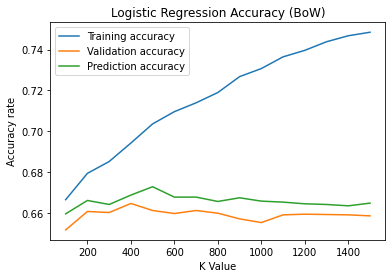

In [217]:
#Accuracy when c = 0.9
training_accuracy_list = []
validation_accuracy_list = []
prediction_accuracy_list = []

for i in range(100,1600,100):
    ta, va, pa = logistic_regression(i,0.9)
    training_accuracy_list.append(ta)
    validation_accuracy_list.append(va)
    prediction_accuracy_list.append(pa)
x = np.arange(100,1600,100) 
y1 = np.array(training_accuracy_list)
y2 = np.array(validation_accuracy_list)
y3 = np.array(prediction_accuracy_list)

# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

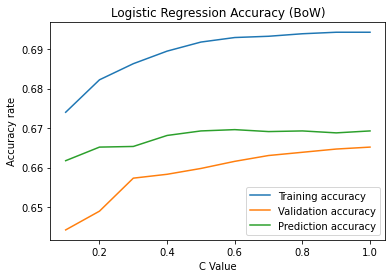

In [239]:
#Accuracy when K = 400
training_accuracy_list = []
validation_accuracy_list = []
prediction_accuracy_list = []


for i in range(1,11,1):
    ta, va, pa = logistic_regression(400,i/10)
    training_accuracy_list.append(ta)
    validation_accuracy_list.append(va)
    prediction_accuracy_list.append(pa)

x = np.arange(0.1,1.1,0.1) 
y1 = np.array(training_accuracy_list)
y2 = np.array(validation_accuracy_list)
y3 = np.array(prediction_accuracy_list)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("C Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

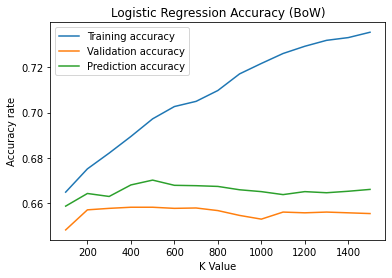

In [242]:
#Accuracy when c = 0.4
training_accuracy_list = []
validation_accuracy_list = []
prediction_accuracy_list = []


for i in range(100,1600,100):
    ta, va, pa = logistic_regression(i,0.4)
    training_accuracy_list.append(ta)
    validation_accuracy_list.append(va)
    prediction_accuracy_list.append(pa)

x = np.arange(100,1600,100) 
y1 = np.array(training_accuracy_list)
y2 = np.array(validation_accuracy_list)
y3 = np.array(prediction_accuracy_list)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

In [ ]:
#Finla model: K = 500, c = 0.4
x_train_chi_lr_final, x_test_chi_lr_final = chi(500)
lr_final = LogisticRegression(solver= 'newton-cg', C = 0.4, max_iter = 2000).fit(x_train_chi_lr_final, y_train)
 

### Model: SVM

**BoW**

In [246]:
from sklearn.svm import SVC
x_train_chi_svm, x_test_chi_svm = chi(500)


In [244]:
gs_svc = GridSearchCV(SVC(), param_grid={"kernel":('linear', 'poly', 'rbf'), "C":[0.1,0.2,0.3,0.4,0.5,0.6],"decision_function_shape":('ovo','ovr')})  
gs_svc.fit(x_train_chi, y_train)



GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                         'decision_function_shape': ('ovo', 'ovr'),
                         'kernel': ('linear', 'poly', 'rbf')})

In [245]:
print(gs_svc.best_params_)

{'C': 0.6, 'decision_function_shape': 'ovo', 'kernel': 'linear'}


In [247]:
#C, kernel, degree, gamma, max_iter, decision_function_shape
from sklearn.svm import SVC

clf = SVC(kernel="linear", C = 0.6, decision_function_shape = 'ovo').fit(x_train_chi_svm, y_train)
y_train_predicted = clf.predict(x_train_chi_svm)
print("training accuracy ", np.mean(y_train_predicted == y_train))
clf_acc = np.mean(cross_val_score(clf,x_test_chi_svm,y_valid,cv = 5))
print('validation accuracy: ' ,clf_acc)
# y_predicted = lr.predict(x_test_chi)
print('prediction accuracy: ',clf.score(x_test_chi_svm, y_valid))


training accuracy  0.6961839842008027
validation accuracy:  0.6494676494676493
prediction accuracy:  0.6568386568386568


In [ ]:

def gs_result_chi():
    best_params_chi = []
    best_scores_chi = []
    
    for i in range(500,2000,500):
        gs_params_chi, gs_score_chi = gs_LogisticRegression(x_train_chi)
        best_params_chi.append(gs_params_chi)
        best_scores_chi.append(gs_score_chi)

    return best_params_chi, best_scores_chi, x_train_chi, x_test_chi

best_params_chi, best_scores_chi, x_train_chi, x_test_chi = gs_result_chi()